# Fitting Parameters for Virus Model

Analysis of the virus model.

 We will fit each of these patients separately, obtaining different values of parameters.

**Fitting**

 There are 6 patients with one value to fit. So, there are 6 different fits.


 Influenza, SARS and SARS-CoV3 in Tellurium

## A simple target cell-limited model, T ==> E ==> I --> produce V:
 T - number of target cells
 E - number of exposed cells (virus replicating inside, not yet spreading virus)
 I - number of infected cells (active virus production)
 V - viral titre, in units of TCID50/ml of biofluid wash (for Influenza)

# The ODEs
 dT/dt = - beta*T*V
 dE/dt =   beta*T*V - kappa*E;
 dI/dt =   kappa * E - delta*I;
 dV/dt =   p*y(I) - c*y(V);

 All viral data is in log10(load),...
 log10(load predicted by model) may be needed for data fitting


Influenza.csv
 Influenza A data - 5 patients
 viral levels in log10(TCID50 / ml of nasal wash)
 time in days since volunteer exposure
 each line in the array is an individual volunteer



SARS_CoV2_sputum.csv and SARS_CoV2_nasal.csv
 SARS-CoV-2 data - 9 patients,
 for each patient - viral loads from lungs (sputum) and from nasal cavity (swab)
 viral levels in log10(RNA copies / ml sputum), ...
 respectively log10(RNA copies / nasal swab)
 time in days since symptoms onset
 corresponding lines in the two arrays belong to an individual patient



SARS.csv
 SARS data recorded from 12 patients;
 included them just for comparison, probably too few datapoints for model inference
virus_analysis.py [python] format: unix; [1,1]                                                                                                                                   
viral levels in log10(RNA copies / ml of nasopharingeal aspirate)
 time - only three samples per patient, at 5, 10 and 15 days post symptoms onset
"""

In [1]:
# Imports
import lmfit
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import SBstoat
import tellurium as te
import matplotlib
import pickle
%matplotlib inline

In [64]:
IS_PLOT = True
VIRUS = "V"
PATIENTS = ["P%d" % n for n in range(1, 7)]
DIR = "/home/ubuntu/SBstoat/examples/virus"
INPUT_FILE =  os.path.join(DIR, "Influenza.csv")
NUM_BOOTSTRAP_ITERATIONS = 10000
PARAM_BETA = "beta"
PARAM_KAPPA = "kappa"
PARAM_P = "p"
PARAM_C = "c"
PARAM_DELTA = "delta"
PARAMS = [PARAM_BETA, PARAM_KAPPA, PARAM_P, PARAM_C, PARAM_DELTA]
TIME = "time"
PATH_PAT = os.path.join(DIR, "virus_%s.pcl")
PATH_DCT = {p: PATH_PAT % p for p in PATIENTS }

In [65]:
PATH_DCT

{'P1': '/home/ubuntu/SBstoat/examples/virus/virus_P1.pcl',
 'P2': '/home/ubuntu/SBstoat/examples/virus/virus_P2.pcl',
 'P3': '/home/ubuntu/SBstoat/examples/virus/virus_P3.pcl',
 'P4': '/home/ubuntu/SBstoat/examples/virus/virus_P4.pcl',
 'P5': '/home/ubuntu/SBstoat/examples/virus/virus_P5.pcl',
 'P6': '/home/ubuntu/SBstoat/examples/virus/virus_P6.pcl'}

## Antimony Model

In [3]:
ANTIMONY_MODEL  = '''
    // Equations
    E1: T -> E ; beta*T*V ; // Target cells to exposed
    E2: E -> I ; kappa*E ;  // Exposed cells to infected
    E3: -> V ; p*I ;        // Virus production by infected cells
    E4: V -> ; c*V ;        // Virus clearance
    E5: I -> ; delta*I      // Death of infected cells    

    // Parameters - from the Influenza article,
        
    beta = 3.2e-5;  // rate of transition of target(T) to exposed(E) cells, in units of 1/[V] * 1/day
    kappa = 4.0;    // rate of transition from exposed(E) to infected(I) cells, in units of 1/day
    delta = 5.2;    // rate of death of infected cells(I), in units of 1/day
    p = 4.6e-2;     // rate virus(V) producion by infected cells(I), in units of [V]/day
    c = 5.2;        // rate of virus clearance, in units of 1/day

    // Initial conditions
    T = 4E+8 // estimate of the total number of susceptible epithelial cells
             // in upper respiratory tract)
    E = 0
    I = 0
    V = 0.75 // the dose of virus in TCID50 in Influenza experiment; could be V=0 and I = 20 instead for a natural infection

'''

## Functions

## Data Setup

In [4]:
"""
Transform the input data
"""

# Convert input file to correct format
dataDF = pd.read_csv(INPUT_FILE, header=None)
dataDF = dataDF.transpose()
dataDF.index.name = "time"
patientDct = {p: "P%d" % (p+1) for p in range(6)}
dataDF = dataDF.rename(columns=patientDct)
observedTS = SBstoat.NamedTimeseries(dataframe=dataDF)
print(observedTS)


       P1   P2   P3   P4   P5   P6
time                              
0.0   2.0  1.0  2.5  3.5  2.5  4.0
1.0   5.5  6.0  5.0  5.5  3.0  5.0
2.0   4.0  3.0  5.0  6.5  6.5  5.5
3.0   5.5  1.5  3.0  5.5  6.5  7.5
4.0   3.0  3.5  5.5  3.5  2.0  5.5
5.0   0.0  1.3  3.5  4.0  0.8  1.3
6.0   0.0  0.0  0.0  0.0  0.0  0.0


The following is a plot of the Influenza data and the simulation results for the 6 patients, P1-P6.

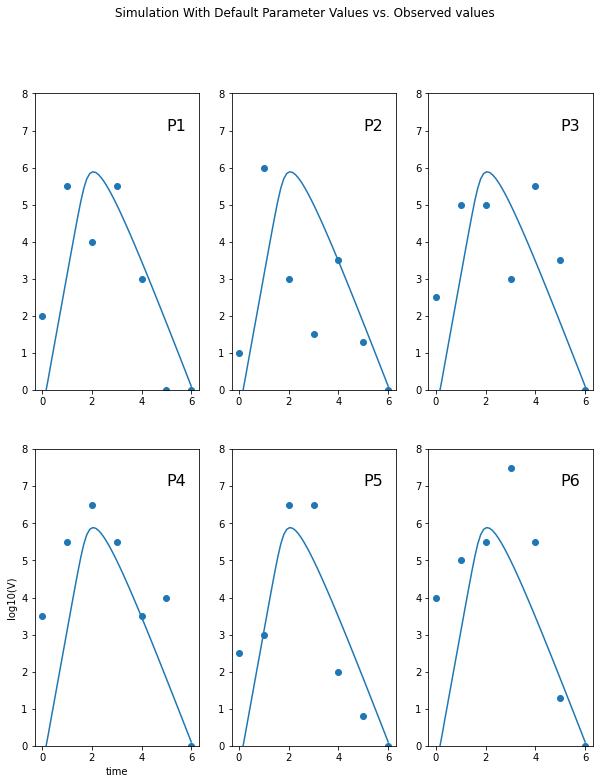

In [44]:
# Compare baseline simulation with observed values
numRow = 2
numCol = 3
rr = te.loada(ANTIMONY_MODEL)
estimates = rr.simulate(0, 6)
v_estimate = np.log10(estimates["[V]"])
COLORS = ["r", "grey", "b", "g", "yellow", "pink"]
fig, axes = plt.subplots(numRow, numCol, figsize=(10, 12))
for idx, patient in enumerate(observedTS.colnames):
    if idx < numCol:
        row = 0
    else:
        row = 1
    col = idx - row*numCol
    ax = axes[row, col]
    if idx == 3:
        ax.set_xlabel("time")
        ax.set_ylabel("log10(V)")
    color = COLORS[idx]
    ax.scatter(observedTS[TIME], observedTS[patient])
    ax.plot(estimates[TIME], v_estimate)
    _ = ax.text(5, 7, "%s"% patient, fontsize=16)
    ax.set_ylim([0, 8])
_ = plt.suptitle("Simulation With Default Parameter Values vs. Observed values")

## Construct Parameter Fittings
This section constructs fitted values using bootstrapping.
This is a computationally intensive procedure. So, results from a past parameter fit are saved in PICKLE_FILE.
The plots constructed in the next section

In [6]:
# Do some fits
# Specify the parameter values
parameterDct = {}
SBstoat.ModelFitter.addParameter(parameterDct, "beta", 0, 10e-5, 3.2e-5)
SBstoat.ModelFitter.addParameter(parameterDct, "kappa", 0, 10, 4.0)
SBstoat.ModelFitter.addParameter(parameterDct, "delta", 0, 10, 5.2)
SBstoat.ModelFitter.addParameter(parameterDct, "p", 0, 1, 4.6e-2)
SBstoat.ModelFitter.addParameter(parameterDct, "c", 0, 10, 5.2)

In [7]:
def extractPatientData(timeseries, patient):
     newTimeseries = timeseries.copy()
     newTimeseries[VIRUS] = newTimeseries[patient]
     return newTimeseries.subsetColumns([VIRUS])

In [8]:
def transformData(timeseries):
    """
    Changes the timeseries to log units
    """
    arr = np.array([1 if v < 1 else v
          for v in timeseries[VIRUS]])
    timeseries[VIRUS] = np.log10(arr)
    return timeseries

In [9]:
def transformDataArr(timeseries):
    """
    Changes the timeseries to log units
    """
    arr = np.array([1 if v < 1 else v
          for v in timeseries[VIRUS]])
    return np.log10(arr)

In [66]:
# Create bootstrapped fitters for all patients
def mkFitter(patient, isBootstrap=True):
    """
    Creates a fitter for the patient and runs
    bootsrapping. Serializes the fitter to PATH_DCT[patient]/

    Parameters
    ----------
    patient: str
    
    Returns
    -------
    ModelFitter
    """
    parameterDct = {}
    SBstoat.ModelFitter.addParameter(parameterDct, "beta", 0, 10e-5, 3.2e-5)
    SBstoat.ModelFitter.addParameter(parameterDct, "kappa", 0, 10, 4.0)
    SBstoat.ModelFitter.addParameter(parameterDct, "delta", 0, 10, 5.2)
    SBstoat.ModelFitter.addParameter(parameterDct, "p", 0, 1, 4.6e-2)
    SBstoat.ModelFitter.addParameter(parameterDct, "c", 0, 10, 5.2)
    # Obtain the input data
    patientObservedTS = extractPatientData(observedTS, patient)
    fittedDataTransformDct = {VIRUS: transformDataArr}  # do fit in log units

    # Fit parameters to ts1
    fitter = SBstoat.ModelFitter(ANTIMONY_MODEL,
        patientObservedTS, ["beta","kappa","delta","p","c"],
        fittedDataTransformDct=fittedDataTransformDct,
        parameterDct=parameterDct)
    fitter.fitModel()
    # Do the bootstrap
    reportInterval = int(NUM_BOOTSTRAP_ITERATIONS/10)
    if isBootstrap:
        fitter.bootstrap(numIteration=NUM_BOOTSTRAP_ITERATIONS,
              serializePath=PATH_DCT[patient],
              reportInterval=reportInterval)
    #
    return fitter

In [11]:
# Construct the parameter fits if they do not exist already
fitters = []
for patient in patientDct.values():
    if os.path.isfile(PATH_DCT[patient]):
        fitter = SBstoat.ModelFitter.deserialize(PATH_DCT[patient])
    else:
        print("\n\n*** Processing patient %s""" % patient)
        fitter = mkFitter(patient)
        fitters.append(fitter)
        fitter.roadrunnerModel = None  # Cannot serialize this object
    fitters.append(fitter)


## Do a Single Fit

In [12]:
fitter = mkFitter("P1", isBootstrap=False)
print(fitter.params)

Parameters([('beta', <Parameter 'beta', value=5.000220727907727e-05, bounds=[0:0.0001]>), ('kappa', <Parameter 'kappa', value=9.881360008246459, bounds=[0:10]>), ('delta', <Parameter 'delta', value=3.984529310512751, bounds=[0:10]>), ('p', <Parameter 'p', value=0.5346886323295384, bounds=[0:1]>), ('c', <Parameter 'c', value=5.837951642029653, bounds=[0:10]>)])


In [13]:
fittedTS = fitter.simulate(fitter.params, startTime=0, endTime=6, numPoint=100)

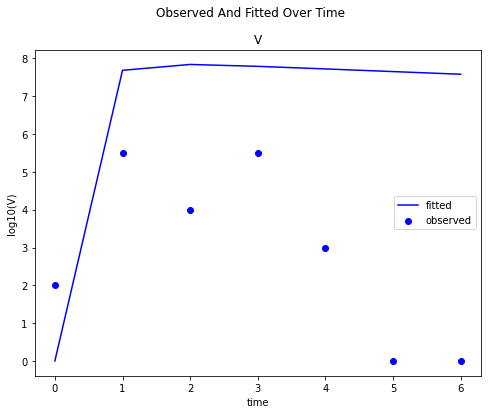

In [14]:
fitter = mkFitter("P1", isBootstrap=False)
fitter.plotFitAll(numRow=2, numCol=2, ylabel="log10(V)")

## Analysis of Bootstrapping Results

## Analysis of Fitting Results

In [15]:
def simulateWithBootstrapParameters(fitter):
    """
    Runs a simulation using the bootstrap parameter estimates.
    
    Parameters
    ----------
    fitter: ModelFitter
    
    Return
    ------
    NamedTimeseries: result of simulation
    """
    # Construct lmfit parameters
    fitter._initializeRoadrunnerModel()
    params = lmfit.Parameters()
    for name in fitter.bootstrapResult.meanDct.keys():
        value=fitter.bootstrapResult.meanDct[name]
        params.add(name, value=value, min=value*0.99, max=value*1.01)
    _ = fitter._residuals(params=params)

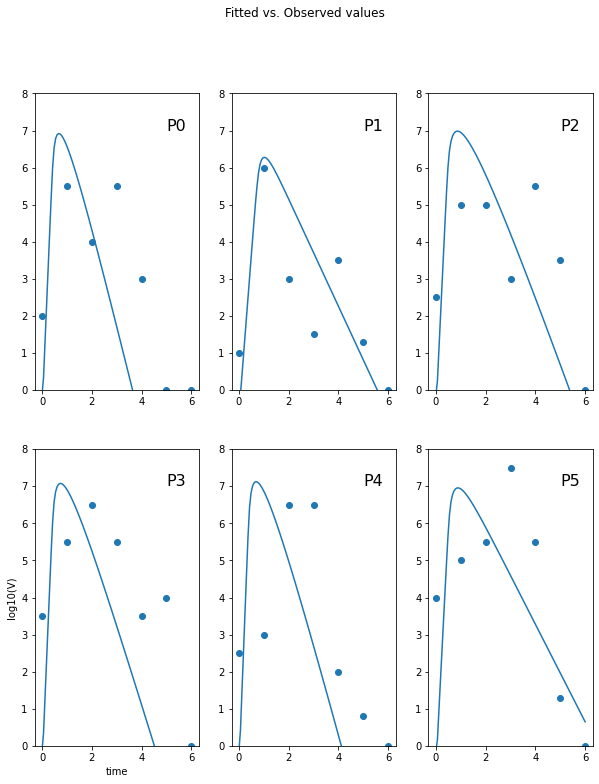

In [43]:
# Plot fits for each patient
names = ["P%d" % (p+1) for p in patientDct.keys()]
numCol = 3
numRow = 2
fig, axes = plt.subplots(numRow, numCol, figsize=(10, 12))
for idx, patient in enumerate(patientDct.keys()):
    if idx < numCol:
        row = 0
    else:
        row = 1
    col = idx - row*numCol
    ax = axes[row, col]
    if idx == 3:
        ax.set_xlabel("time")
        ax.set_ylabel("log10(V)")
    fitter = fitters[patient]
    data = fitter.simulate(params=fitter.bootstrapResult.params, numPoint=100)
    dataTS = SBstoat.NamedTimeseries(namedArray=data)
    dataTS["V"] = np.log10(dataTS["V"])
    ax.plot(dataTS[TIME], dataTS["V"])
    ax.scatter(fitter.observedTS[TIME], fitter.observedTS["V"])
    ax.set_ylim([0, 8])
    _ = ax.text(5, 7, "P%s" % patient, fontsize=16)
_ = plt.suptitle("Fitted vs. Observed values")

In [58]:
parameterDct['beta'].value

3.2e-05

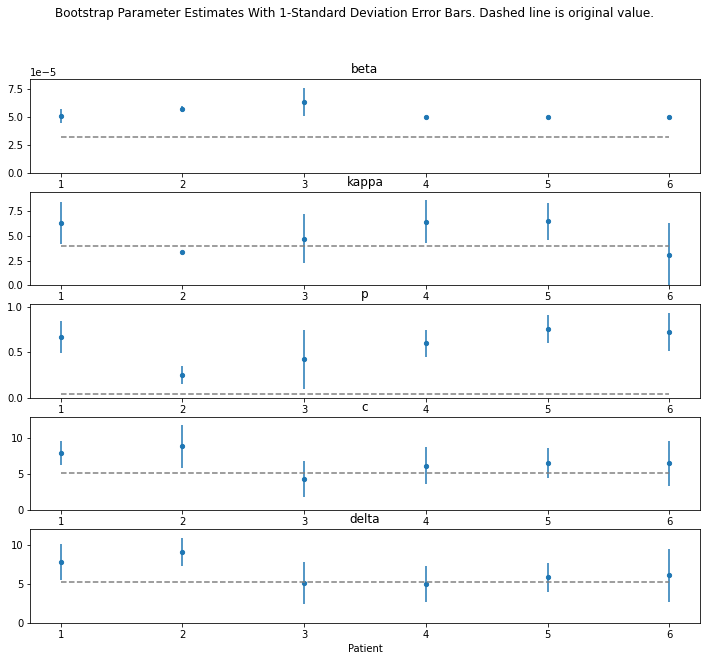

In [63]:
# Construct parameter plots
# TODO: Do horizontal plot of original values
patients = [p+1 for p in patientDct.keys()]
fig, axes = plt.subplots(5,1, figsize=(12,10))
for pos, param in enumerate(PARAMS):
    ax = axes[pos]
    param = PARAMS[pos]
    means = [f.bootstrapResult.meanDct[param] for f in fitters]
    stds = [f.bootstrapResult.stdDct[param] for f in fitters]
    y_upper = max([s + m for s, m in zip(stds, means)])*1.1
    ax.errorbar(patients, means, yerr=stds, linestyle="")
    ax.scatter(patients, means, s=18.0)
    values = np.repeat(parameterDct[param].value, len(patients))
    ax.plot(patients, values, linestyle="dashed", color="grey")
    ax.set_title(param)
    ax.set_ylim([0, y_upper])
    if pos == len(PARAMS) - 1:
        ax.set_xlabel("Patient")
_ = plt.suptitle("Bootstrap Parameter Estimates With 1-Standard Deviation Error Bars. Dashed line is original value.")
